# Distribution des naissances dans le temps 

Dans ce carnet est proposée une analyse de la distribution dans le temps des années de naissance de la population retenue, et la mise en évidence de générations.

On met aussi en évidence l'évolution dans le temps des genres

In [1]:
### Librairie à installer dans l'environnement conda (si on exécute en local)
# qui sera choisi pour exécuter le carnet
from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

In [2]:
### Librairies déjà installées avec Python
import pprint
import csv
import sys

import sqlite3 as sql

import time
import datetime
from dateutil import parser

from importlib import reload
from shutil import copyfile


In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## SPARQL Query qui récupère les données

On exécute la requête grâce à une fonction de la librairie locale qui réalise la mise en forme

In [ ]:
## define SPARQL enpoint
endpoint = "https://ag1mftakvrjmpfvp.allegrograph.cloud/repositories/judges"

In [5]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>


SELECT  ?s (MAX(?label) as ?label) (xsd:integer(MAX(?birthDate)) as ?birthDate) (MAX(?gen) as ?gen)
WHERE {
    GRAPH <https://github.com/TanguyGodat/Judges/blob/main/graphs/wikidata_imported_data.md>
    # GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?s wdt:P21 ?gen;
            rdfs:label ?label;
            wdt:P569 ?birthDate.
          }
}
GROUP BY ?s
"""

In [6]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [7]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

35091


[['http://www.wikidata.org/entity/Q7422125',
  'Sarah Bradley',
  '1956',
  'http://www.wikidata.org/entity/Q6581072'],
 ['http://www.wikidata.org/entity/Q336459',
  'Geoffrey Lawrence, 1st Baron Oaksey',
  '1880',
  'http://www.wikidata.org/entity/Q6581097'],
 ['http://www.wikidata.org/entity/Q55728795',
  'Roh Tae-ak',
  '1962',
  'http://www.wikidata.org/entity/Q6581097']]

In [8]:
### Créer un DataFrame à partir du résultat
df_p = pd.DataFrame(r)
df_p.columns = ['personUri', 'personLabel', 'birthYear', 'genderUri']
df_p.head()

,personUri,personLabel,birthYear,genderUri
0,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,http://www.wikidata.org/entity/Q6581072
1,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,http://www.wikidata.org/entity/Q6581097
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,http://www.wikidata.org/entity/Q6581097
3,http://www.wikidata.org/entity/Q1170754,Tielman Roos,1879,http://www.wikidata.org/entity/Q6581097
4,http://www.wikidata.org/entity/Q5080447,Charles M. Cooke,1844,http://www.wikidata.org/entity/Q6581097


In [9]:
df_p.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35091 entries, 0 to 35090
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   personUri    35091 non-null  object
 1   personLabel  35091 non-null  object
 2   birthYear    35091 non-null  object
 3   genderUri    35091 non-null  object
dtypes: object(4)
memory usage: 1.1+ MB


### Vérifier les genres présents directement sur la base de données


Voir les requêtes correspondantes dans le [SPARQL notebook qui créé la population](../../sparqlbooks/wikidata_import_population.sparqlbook)

### Ajouter une colonne au DataFrame avec le code du genre 

In [10]:
### On créé d'abord une fonction qui effectue le travail

## l'argument de la fonction 'g_uri' est un nom choisi librement
# il est ensuite appelé dans la fonction comme variable
# et contient la valeur introduite lors de l'utilisation de la fonction 
def code_gender(g_uri):
    if g_uri == 'http://www.wikidata.org/entity/Q6581097':
        # genre masculin
        a = 'M'
    elif g_uri =='http://www.wikidata.org/entity/Q6581072':
        # genre féminin
        a = 'F'
    else:
        # genre autre
        a = 'A'
    return a    

In [11]:
### On teste la fonction
print(code_gender('http://www.wikidata.org/entity/Q48270'))

A


In [12]:
### On ajoute une nouvelle colonne et y on met pour chaque ligne le résultat de la fonction
df_p['genCode'] = df_p.apply(lambda x: code_gender(x['genderUri']), axis=1)

In [13]:
### On inspecte les cinq premières lignes qui ont la valeur 'A' = autre
df_p[df_p['genCode']=='A'][:5]

,personUri,personLabel,birthYear,genderUri,genCode
472,http://www.wikidata.org/entity/Q7926817,Victoria Kolakowski,1961,http://www.wikidata.org/entity/Q1052281,A
2341,http://www.wikidata.org/entity/Q120809880,Seth Marnin,1901,http://www.wikidata.org/entity/Q2449503,A
10696,http://www.wikidata.org/entity/Q22279144,Kael McKenzie,1971,http://www.wikidata.org/entity/Q2449503,A
27603,http://www.wikidata.org/entity/Q106785053,John Altman,1944,http://www.wikidata.org/entity/Q27679684,A
29617,http://www.wikidata.org/entity/Q55064939,Q55064939,1969,http://www.wikidata.org/entity/Q1052281,A


## Effectifs par année

In [14]:
### On inspecte les valeurs de la colonne 'birthYear' 
# et on observe que le type de données est 'object', ici texte
df_p['birthYear'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 35091 entries, 0 to 35090
Series name: birthYear
Non-Null Count  Dtype 
--------------  ----- 
35091 non-null  object
dtypes: object(1)
memory usage: 274.3+ KB


In [15]:
### On transforme le type de valeur de la colonne BirthYear
# de objet à entier
df_p['birthYear'] = df_p['birthYear'].astype(int)

In [16]:
### On transforme en DataFrame le résultat du regroupement par année
# noter qu'un ajoute un filtre pour que l'année maximale de naissance soit 2000
years_count = pd.DataFrame(df_p[df_p['birthYear'] < 2001].groupby('birthYear').size())\
                .reset_index(drop=False)
years_count.columns=['year','effectif']
years_count

,year,effectif
0,1800,122
1,1801,115
2,1802,109
3,1803,94
4,1804,110
...,...,...
192,1992,3
193,1993,2
194,1996,2
195,1998,3


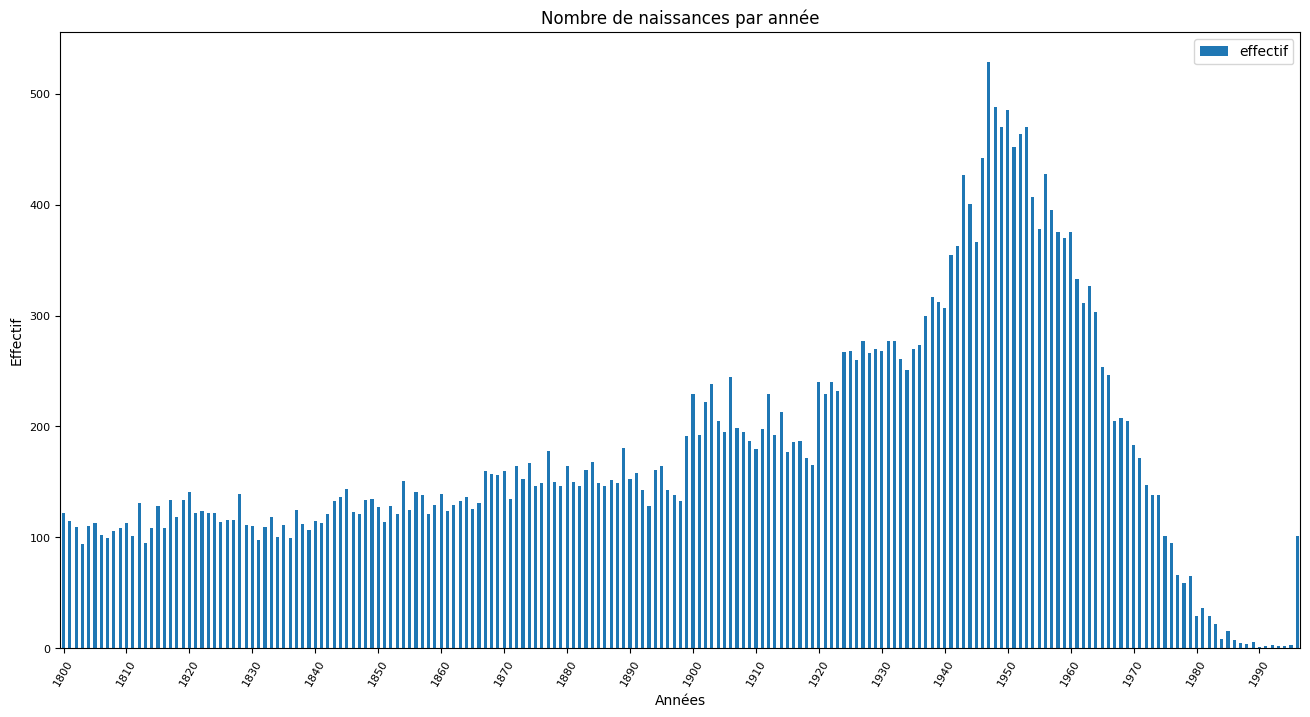

In [17]:
### Représentation graphique des effectifs par année

ax = years_count.plot(x='year', y='effectif', kind='bar',rot=60, fontsize=8, figsize=(16,8))


max_xticks = 20
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

plt.ylabel('Effectif')
plt.xlabel('Années')
plt.title('Nombre de naissances par année')
plt.show()

## Regrouper les effectifs par périodes de 25 ans

In [46]:
### Créer une copie indépendante du DataFrame (attention aux copies de variables qui sont seulement des alias) 
cdf_p = df_p[df_p['birthYear'] < 2001].copy(deep=True)

In [47]:
cdf_p.head(3)

,personUri,personLabel,birthYear,genderUri,genCode
0,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,http://www.wikidata.org/entity/Q6581072,F
1,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,http://www.wikidata.org/entity/Q6581097,M
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,http://www.wikidata.org/entity/Q6581097,M


In [48]:
### Année minimale et maximale dans la population
print(min(cdf_p['birthYear']), max(cdf_p['birthYear']))

1800 2000


### Codage par période de vingt-cinq ans

In [56]:
### Créer une liste d'années pour séparer en périodes de 25 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
l_25 = list(range(1801, 2025, 25))
print(l_25[:5],l_25[-5:])

[1801, 1826, 1851, 1876, 1901] [1901, 1926, 1951, 1976, 2001]


In [57]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

cdf_p['periodes'] = pd.cut(cdf_p['birthYear'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['periodes'] = cdf_p['periodes'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,birthYear,genderUri,genCode,periodes
0,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,http://www.wikidata.org/entity/Q6581072,F,1951-1975
1,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,http://www.wikidata.org/entity/Q6581097,M,1876-1900
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,http://www.wikidata.org/entity/Q6581097,M,1951-1975


In [59]:
### compter les naissances par périodes de 25 ans
cdf_p.groupby(by='periodes', observed=True).size()

periodes
1801-1825    2871
1826-1850    2973
1851-1875    3484
1876-1900    3930
1901-1925    5253
1926-1950    8512
1951-1975    7385
1976-2000     561
dtype: int64

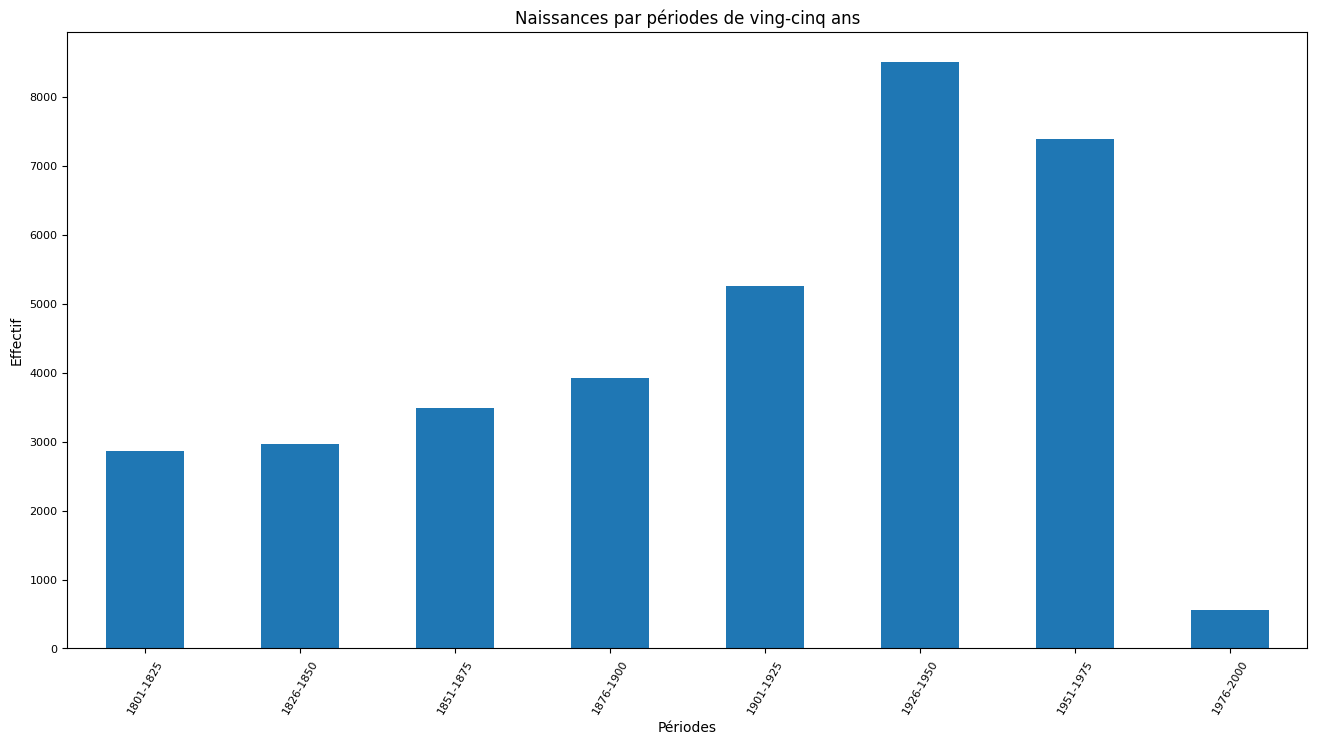

In [60]:
ax = cdf_p.groupby(by='periodes', observed=True).size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

## Ajouter la représentation des genres

In [65]:
### Regrouper et compter avec un fitre sur le genre masculin
gender_m = pd.DataFrame(cdf_p[cdf_p.genCode == 'M'].groupby('periodes', observed=True).size())
gender_m.columns = ['gen_m']
gender_m.tail()


,gen_m
periodes,
1876-1900,3873
1901-1925,5029
1926-1950,7398
1951-1975,5097
1976-2000,323


In [66]:
### Regrouper et compter avec un fitre sur le genre féminin
gender_f = pd.DataFrame(cdf_p[cdf_p.genCode == 'F'].groupby('periodes', observed=True).size())
gender_f.columns = ['gen_f']
gender_f.tail()


,gen_f
periodes,
1876-1900,57
1901-1925,223
1926-1950,1113
1951-1975,2285
1976-2000,238


In [67]:
### Fusionner les deux tableaux en utilisant l'index comme clé de jointure
merged = pd.merge(gender_m, gender_f, left_index=True, right_index=True)
merged.tail()

,gen_m,gen_f
periodes,,
1876-1900,3873,57
1901-1925,5029,223
1926-1950,7398,1113
1951-1975,5097,2285
1976-2000,323,238


In [68]:
### Transformer l'index de séquence à chaîne de caractères
# ce qui est indispensable pour l'affichage dans un graphique
merged.index = merged.index.map(str)
merged.tail()

,gen_m,gen_f
periodes,,
1876-1900,3873,57
1901-1925,5029,223
1926-1950,7398,1113
1951-1975,5097,2285
1976-2000,323,238


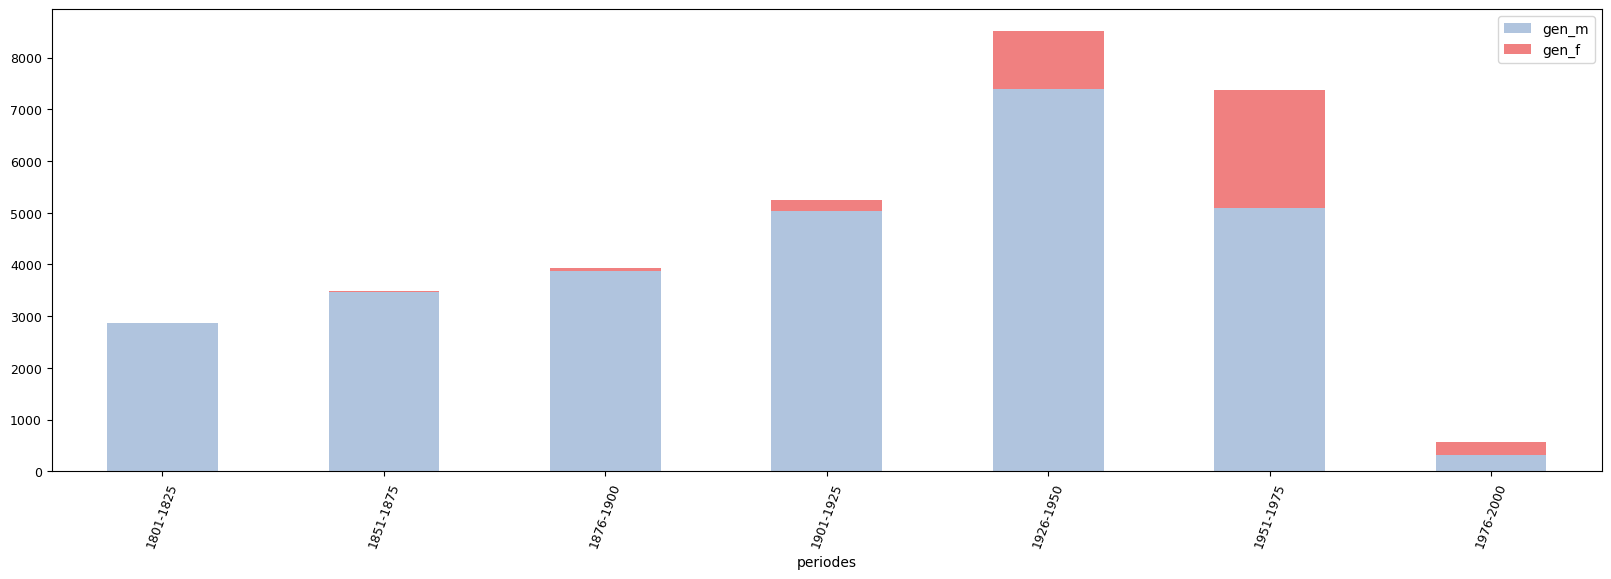

In [69]:
### Documentation
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.bar.html
ax = merged.plot.bar(stacked=True, rot=70, fontsize=9, figsize=(20,6), color=['LightSteelBlue', 'LightCoral'])
plt.show()

### Codage par période de dix ans

Comme on voit bien dans le graphique précédent qu'il y a deux périodes avec des effectifs radicalements différents, 
on restraint la période analysée à l'époque contemporaine et on affine avec un découpage par périodes de dix ans 

In [93]:
l_10 = list(range(1851, 2010, 10))
print(l_10[:5],l_10[-5:])

[1851, 1861, 1871, 1881, 1891] [1961, 1971, 1981, 1991, 2001]


In [95]:
### Découpage par décennies
## fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html

cdf_p['per_10'] = pd.cut(cdf_p['birthYear'], l_10, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
cdf_p['per_10'] = cdf_p['per_10'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
cdf_p.head(3)

,personUri,personLabel,birthYear,genderUri,genCode,periodes,per_10
0,http://www.wikidata.org/entity/Q7422125,Sarah Bradley,1956,http://www.wikidata.org/entity/Q6581072,F,1951-1975,1951-1960
1,http://www.wikidata.org/entity/Q336459,"Geoffrey Lawrence, 1st Baron Oaksey",1880,http://www.wikidata.org/entity/Q6581097,M,1876-1900,1871-1880
2,http://www.wikidata.org/entity/Q55728795,Roh Tae-ak,1962,http://www.wikidata.org/entity/Q6581097,M,1951-1975,1961-1970


In [97]:
### On regroupe par genre comme ci-dessus
gender_m_10 = pd.DataFrame(cdf_p[(cdf_p.genCode == 'M') & (cdf_p.birthYear > 1850)].groupby('per_10', observed=True).size())
gender_m_10.columns = ['gen_m']
gender_m_10.tail()


,gen_m
per_10,
1951-1960,2993
1961-1970,1685
1971-1980,601
1981-1990,72
1991-2000,69


In [99]:
### Idem
gender_f_10 = pd.DataFrame(cdf_p[(cdf_p.genCode == 'F')& (cdf_p.birthYear > 1850)].groupby('per_10', observed=True).size())
gender_f_10.columns = ['gen_f']
gender_f_10.tail()


,gen_f
per_10,
1951-1960,1121
1961-1970,888
1971-1980,408
1981-1990,62
1991-2000,44


In [100]:
merged_10 = pd.merge(gender_m_10, gender_f_10, left_index=True, right_index=True)
merged_10.tail()

,gen_m,gen_f
per_10,,
1951-1960,2993,1121
1961-1970,1685,888
1971-1980,601,408
1981-1990,72,62
1991-2000,69,44


In [101]:
### On transforme le type de valeur de l'index
# et on ajoute une colonne avec le total
merged_10.index = merged_10.index.map(str)
merged_10['tot']=merged_10['gen_m']+merged_10['gen_f']
merged_10.tail()

,gen_m,gen_f,tot
per_10,,,
1951-1960,2993,1121,4114
1961-1970,1685,888,2573
1971-1980,601,408,1009
1981-1990,72,62,134
1991-2000,69,44,113


In [102]:
### On prépare les valeurs pour l'affichage des fréquences (proportion par rapport au total)

# liste qui contient toutes les valeurs à la suite
m_f = merged_10.gen_m.to_list()+merged_10.gen_f.to_list()

# liste d'égale longueur que la précédente qui contient 
# les valeurs de l'index, i.e. les périodes
tot = merged_10.tot.to_list()*2

# liste qui contient les valeurs des fréquences
lp = [round(v/t, 2) for v,t in zip(m_f, tot)]
lp[:3]

[1.0, 0.99, 0.99]

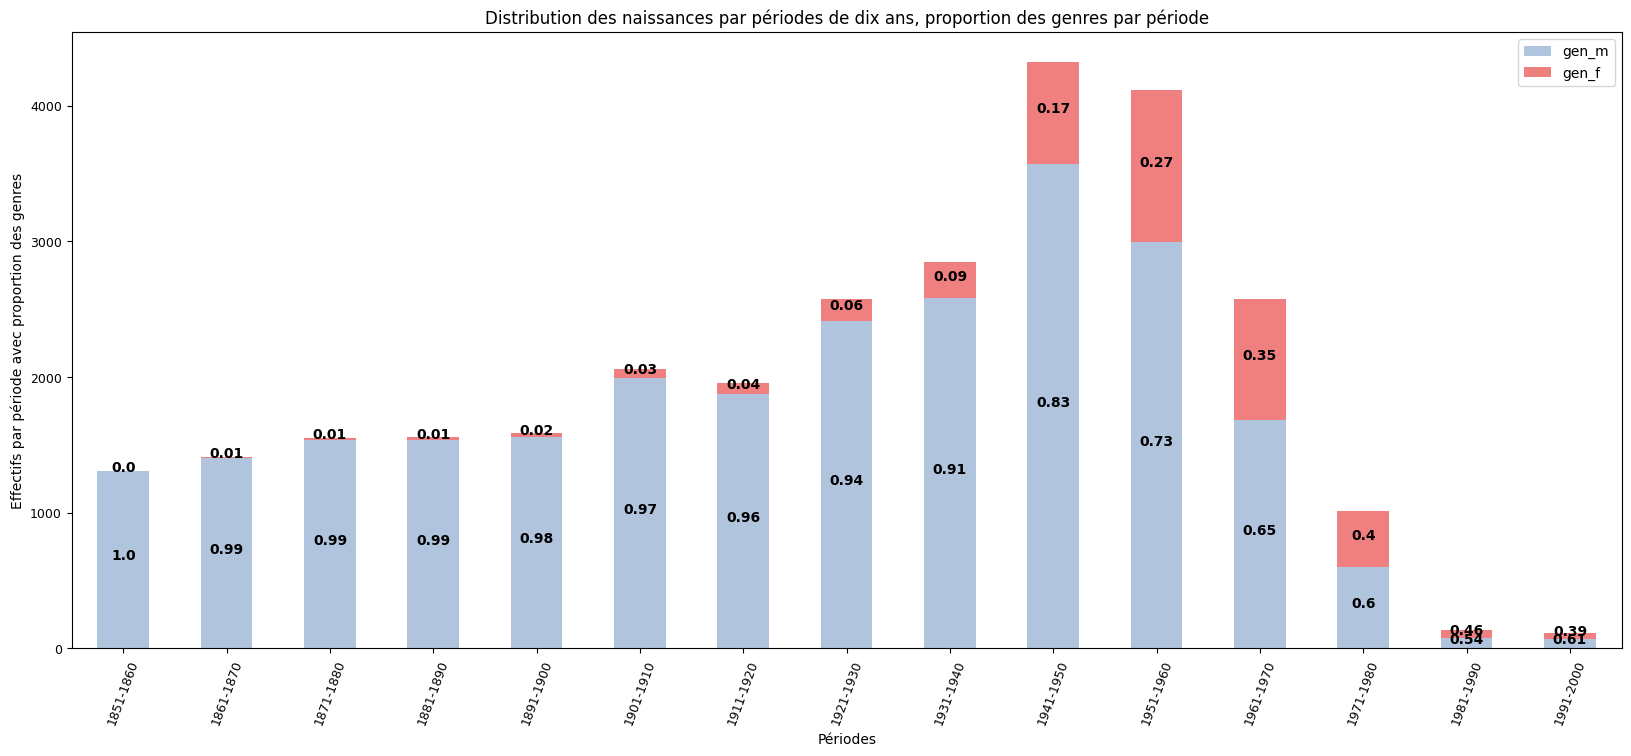

In [103]:
### Graphique avec la distribution par période et genre (M,F)
# Noter que les effectifs du genre 'Autres' étant très faibles,
# on ne les analyse pas de manière sérielle mais on peut les analyser qualitatiement

ax = merged_10.plot.bar(stacked=True, y=['gen_m', 'gen_f'], \
                        rot=70, fontsize=9, figsize=(20,8), color=['LightSteelBlue', 'LightCoral'])


### https://www.pythoncharts.com/matplotlib/stacked-bar-charts-labels/


## On ajoute une étiquette concernant la valeur de fréquence
# à chaque rectangle dans le graphe, en utilisant la list 'lp' préparée précédemment
# Il y a autant de triangles que les valeurs d'index x le nombre de variables

for bar,v in zip(ax.patches,lp): 

    ax.text(
      # Met les étiquette aux centre des rectangles
      bar.get_x() + bar.get_width() / 2,
        
      # Ajoute les coordonnées verticales
      bar.get_height()/2 + bar.get_y(), 
      
      # Ajoute les valeurs
      v,

      # centre et met du style aux étiquettes
      ha='center',
      color='black',
      weight='bold',
      size=10
  )

plt.ylabel('Effectifs par période avec proportion des genres')
plt.xlabel('Périodes')
plt.title('Distribution des naissances par périodes de dix ans, proportion des genres par période')

## On peut enregistrer l'image dans un fichier (noter le dossier créé préalablement)
# qu'on pourra ensuite introduire dans un travail et commenter

# Doc.: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
plt.savefig('./images/naissances_distribution_10ans_genre.jpg', bbox_inches='tight', pad_inches=0.2)
plt.show()